In [3]:
#Importing packages we need
from numpy import genfromtxt #This is used to loading a csv-file as a numpy array
import numpy as np
import scipy.optimize as opt #used to numerically optimize
import matplotlib.pyplot as plt #pyplot is used to plot the data
import pandas as pd
from matplotlib import cm
import numdifftools as nd #Using this package to numerically approximate the hessian matrix

In [4]:
#Locate my folder
my_folder='C:\\Users\\sebkl\\OneDrive\\Uni\\Kandidat\\Financial econometrics\\Assignments\\Assignment 1'
#C:\Users\vjule\OneDrive\Dokumenter\skole\Kandidatfag\Financial_econometrics\Undervisning\Assignments
y_val = genfromtxt(my_folder+'\\xbtusd.csv', delimiter=',') #loading the csv data and storing it as a np array
# xtbusd = y_val[:, 0:4]
Y = y_val[:, 3:4] #Taking the relevant retrended column from the CSV-file 
Y=Y[1:] #First observation is a NaN value and we get rid of that 
T=len(Y) #Finding length of the column which we use to reshape (right now it is a (TX1) np array, I want a 1XT even though the code might still work for the former)
Y=np.reshape(Y,T) #Getting a 1XT np array (so a "standard" np.array with our observations)

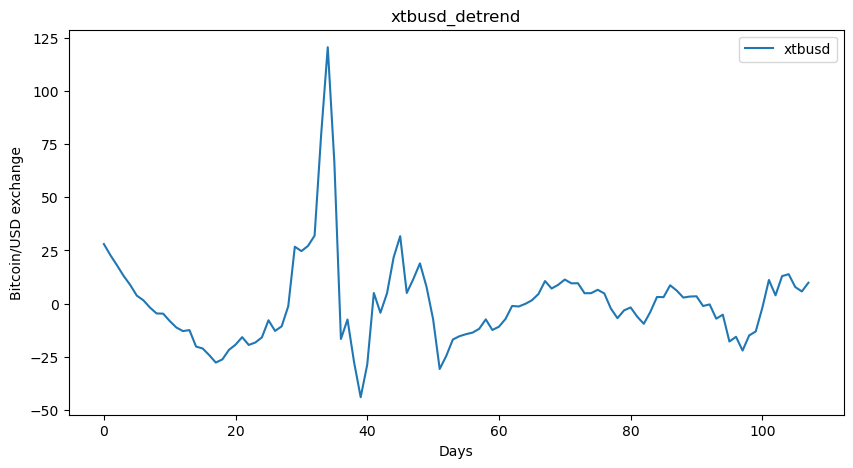

In [5]:
x = np.arange(Y.shape[0])

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(x, Y, label='xtbusd')  # Plot the data
plt.xlabel('Days')
plt.ylabel('Bitcoin/USD exchange')
plt.title('xtbusd_detrend')
plt.legend()

In [6]:
def DAR_likelihood(phi, omega, alpha,):
    T=len(Y)
    
    #Define the series sigma^2_t (sigma2), e_t=x_t-phi*x_{t-1} (e) as empty variables we assign values to later. 
    sigma2=np.zeros(T)
    e=np.zeros(T)
    logli=np.zeros(T)
    
    for t in range(1,T):
        sigma2[t]=omega + alpha*Y[t-1]**2
        e[t]=Y[t]-(1+phi)*Y[t-1]  #### Jeg har ændret til 1+phi, fordi ellers så er phi=1+phi, dette er ikke foreneligt estimat med model
        logli[t]=-0.5*np.log(2*np.pi)-0.5*np.log(sigma2[t])-0.5*e[t]**2/sigma2[t]
    
    LogL=-np.sum(logli)
    #Note we take the expression and multiply with (-1) as we are going to minimize the function in the optimization
    
    return LogL

def optim(x): #defining an optimization function that only can change phi,omega and alpha
    ph,ome,alp=x 
    return DAR_likelihood(phi=ph, omega=ome,alpha=alp)

In [7]:
#Maximization - 
#Note on the optimization: I wish to highlight that the optimazation of the DAR-likelihood is rather complex and some
# - optimizers (like Newton-CG and L-BFGS-B) have an issue getting satisfying convergence. We use SLSQP which is ideal
#- for mathematical problems for which the objective function and the constraints are twice continuously differentiable.
#- Nevertheless, when using SLSQP we can't get the inverse hessian directly from the computation (from scipy) which we used
#- for the ARCH(1) optimizations. In order to get the hessian and thereby the standard errors of the estimates we use
#- numdifftools which approximate the hessian numerically. 
Par0=np.array([0.0,0.05,0.5]) #initial guesses
res=opt.minimize(optim, Par0, method='SLSQP', bounds=((None,None),(0,None),(0,None))) #optimizing using the SLSQP (sequential least squares programming) algorithm
# Jeg har ændret bound på alpha fra none til 0    phi was set to 0.0001

In [8]:
res.x

array([-0.0985669 , 47.66526198,  0.18591416])

In [9]:
H = nd.Hessian(optim)([0.9014295 , 47.66480794,  0.18590847]) #Approximating the hessian numerically evaluated at the parameter estimates
#Neglect the warning message in this case

In [10]:
V_H=np.linalg.inv(H) #Getting the inverse hessian
se_H=np.sqrt(np.diagonal(V_H)) #Getting the standard errors from the inverse hessian

In [11]:
phi_est=res.x[0]
omega_est=res.x[1]
alpha_est=res.x[2]
print('Estimates are given by with std. errors and t_vals in ():')
print('phi_bar_est= '+str(phi_est)+', ( se(.)=' +str(se_H[0])+', t_val= ' +str(phi_est/se_H[0])+' )' )
print('omega_est= '+str(omega_est)+', ( se(.)=' +str(se_H[1])+', t_val= ' +str(omega_est/se_H[1])+' )' )
print('alpha_est= '+str(alpha_est)+', ( se(.)=' +str(se_H[2])+', t_val= ' +str(alpha_est/se_H[2])+' )' )

Estimates are given by with std. errors and t_vals in ():
phi_bar_est= -0.09856689618033232, ( se(.)=0.15936383446989436, t_val= -0.6185022875999682 )
omega_est= 47.665261982295355, ( se(.)=7.79238860788329, t_val= 6.11690001369722 )
alpha_est= 0.1859141571609705, ( se(.)=0.035537353354169236, t_val= 5.231513875221073 )


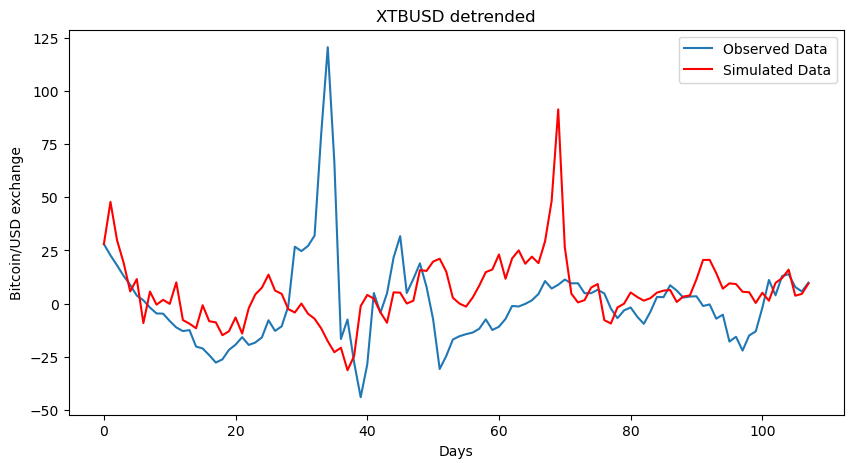

In [13]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(x, Y, label='Observed Data')  # Plot the data
plt.plot(x, simulated_series, label='Simulated Data', color='red')
plt.xlabel('Days')
plt.ylabel('Bitcoin/USD exchange')
plt.title('XTBUSD detrended')
plt.legend()